# Stock Price Trend Prediction with LSTM
**Author:** G. Nishitha — AIML Intern

**Run environment:** Google Colab

---

This notebook is a ready-to-run template for fetching stock data with `yfinance`, preprocessing, building an LSTM model using TensorFlow/Keras, training, and visualizing predictions. Follow the comments and run cells sequentially.

In [1]:
# Install required libraries (run in Colab)
!pip install yfinance --quiet
!pip install -q tensorflow==2.12.0
!pip install -q scikit-learn
!pip install -q pandas
!pip install -q matplotlib

print('Installs finished')

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
Installs finished


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print('Imports ready')

Imports ready


In [3]:
pip install yfinance tensorflow scikit-learn pandas matplotlib joblib


## 1. Download historical stock data
Change the `TICKER` variable below to download a different stock (e.g., 'AAPL', 'MSFT').

In [4]:
TICKER = 'AAPL'
START = '2015-01-01'
END = None  # None uses today's date

df = yf.download(TICKER, start=START, end=END)
df.head()

/tmp/ipython-input-1340790947.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261042,24.729265,23.821666,24.718169,212818400
2015-01-05,23.577578,24.110154,23.391177,24.030267,257142000
2015-01-06,23.579800,23.839430,23.218091,23.641933,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829128,24.886824,24.121246,24.238858,237458000


## 2. Preprocess data
We will use the `Close` price. Scale to [0,1] using `MinMaxScaler` and create sequences for LSTM.

In [5]:
# --- Step 4: Data Preprocessing ---

# 1️⃣ Keep only the 'Close' price column and remove any missing values
data = df[['Close']].dropna()

# 2️⃣ Normalize the data to [0, 1] so all values are in the same scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3️⃣ Function to create sequences of 60 days
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # 60 previous closing prices
        y.append(data[i, 0])               # price on the 61st day
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled_data, SEQ_LEN)

# 4️⃣ Reshape X for LSTM: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("✅ Data prepared successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Data prepared successfully!
X shape: (2658, 60, 1)
y shape: (2658,)


In [6]:
data = df[['Close']].dropna()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)
X = X.reshape((X.shape[0], X.shape[1], 1))

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (2658, 60, 1)
y shape: (2658,)


In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes:', X_test.shape, y_test.shape)

Train shapes: (2126, 60, 1) (2126,)
Test shapes: (532, 60, 1) (532,)


In [8]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - loss: 0.0296 - val_loss: 0.0034
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0011 - val_loss: 0.0020


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


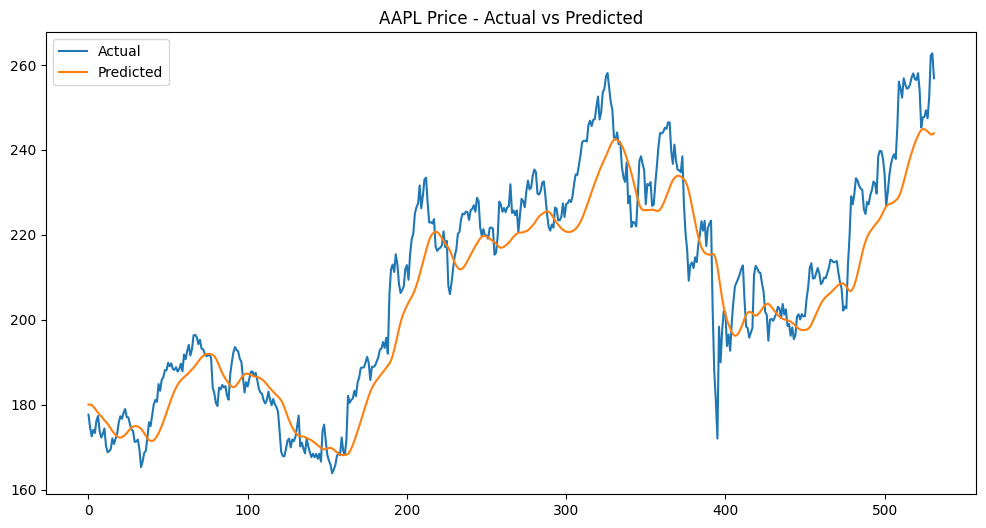

In [10]:
preds = model.predict(X_test)
preds_inv = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(preds_inv, label='Predicted')
plt.title(f'{TICKER} Price - Actual vs Predicted')
plt.legend()
plt.show()

In [11]:
model.save('lstm_stock_model.h5')
import joblib
joblib.dump(scaler, 'scaler.save')
print('Saved model and scaler')

Saved model and scaler


## Optional Streamlit deployment snippet
Save the code below as `app.py` and run `streamlit run app.py`.

In [12]:
streamlit_code = '''
import streamlit as st
import yfinance as yf
import joblib
from tensorflow.keras.models import load_model

model = load_model('lstm_stock_model.h5')
scaler = joblib.load('scaler.save')

st.title('Stock Price Predictor')
T = st.text_input('Ticker', 'AAPL')
if st.button('Predict'):
    df = yf.download(T, period='1y')
    data = df[['Close']].dropna()
    scaled = scaler.transform(data)
    x = scaled[-60:]
    x = x.reshape(1, x.shape[0], 1)
    pred = model.predict(x)
    pred_inv = scaler.inverse_transform(pred)
    st.write('Predicted next close:', float(pred_inv))
'''

with open('app.py', 'w') as f:
    f.write(streamlit_code)
print('Streamlit app.py created')

Streamlit app.py created


In [13]:
# --- Step 5.1: Split data into training and testing sets ---

# We'll use 80% of the data for training, 20% for testing
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("✅ Data split complete!")
print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)


✅ Data split complete!
Training samples: (2126, 60, 1)
Testing samples: (532, 60, 1)


In [14]:
# --- Step 5.2: Build the LSTM model ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Sequential model = layers stacked one after another
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # 1st LSTM layer
    Dropout(0.2),  # helps prevent overfitting
    LSTM(32),      # 2nd LSTM layer
    Dropout(0.2),
    Dense(1)       # final output layer (predicting 1 value)
])

# Compile the model — define how it learns
model.compile(optimizer='adam', loss='mse')

# Show model structure
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# --- Step 5.3: Train the LSTM model ---

from tensorflow.keras.callbacks import EarlyStopping

# Stop training early if validation loss stops improving (to avoid overfitting)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,           # increase this (like 50–100) if using GPU
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0171 - val_loss: 0.0030
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 9.0430e-04 - val_loss: 0.0023
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0010 - val_loss: 0.0031


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


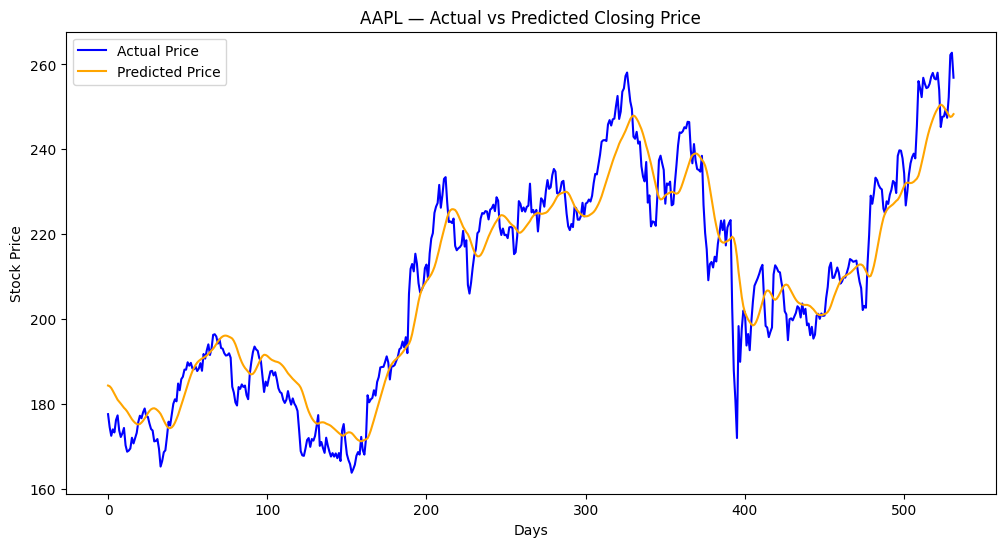

,Actual Price,Predicted Price
0,177.620209,184.360870
1,174.589905,184.195831
2,172.520172,183.780289
3,174.035324,183.125885
4,173.312408,182.403290


In [16]:
# --- Step 6: Make Predictions & Visualize Results ---

import matplotlib.pyplot as plt

# 1️⃣ Use the model to predict on the test data
predictions = model.predict(X_test)

# 2️⃣ Inverse transform (convert scaled values back to original prices)
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# 3️⃣ Create a DataFrame for easy comparison
import pandas as pd
results = pd.DataFrame({
    'Actual Price': actual_prices.flatten(),
    'Predicted Price': predicted_prices.flatten()
})

# 4️⃣ Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(results['Actual Price'], label='Actual Price', color='blue')
plt.plot(results['Predicted Price'], label='Predicted Price', color='orange')
plt.title(f'{TICKER} — Actual vs Predicted Closing Price')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 5️⃣ Print first few results
results.head()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"📊 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")


📊 Mean Absolute Error (MAE): 6.0739
📉 Root Mean Squared Error (RMSE): 7.7982


In [18]:
# --- Step 7.1: Save the trained model and the scaler ---

# Save the model (Keras .h5 format)
model.save('lstm_stock_model.h5')

# Save the scaler using joblib
import joblib
joblib.dump(scaler, 'scaler.save')

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [19]:
# --- Step 7.2: Generate Streamlit app scaffold (app.py) ---

streamlit_code = '''
import streamlit as st
import yfinance as yf
from tensorflow.keras.models import load_model
import joblib
import numpy as np

# Load saved model and scaler
model = load_model('lstm_stock_model.h5')
scaler = joblib.load('scaler.save')

st.title('Stock Price Predictor')

ticker_input = st.text_input('Enter Ticker (e.g. AAPL)', 'AAPL')
if st.button('Predict'):
    # Download recent one year data
    df_pred = yf.download(ticker_input, period='1y')
    data_close = df_pred[['Close']].dropna()
    scaled_data = scaler.transform(data_close)
    # Use last SEQ_LEN days
    seq_len = 60
    x_input = scaled_data[-seq_len:]
    x_input = x_input.reshape(1, seq_len, 1)

    # Make prediction
    pred = model.predict(x_input)
    pred_price = scaler.inverse_transform(pred)

    st.write(f"Predicted next closing price for **{ticker_input}**: ", float(pred_price))
'''

with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("✅ Created app.py for Streamlit deployment")


✅ Created app.py for Streamlit deployment


In [20]:
# --- Save Actual vs Predicted Results as CSV ---

results.to_csv('predicted_vs_actual.csv', index=False)

print("✅ Predicted vs Actual results saved successfully as 'predicted_vs_actual.csv'")


✅ Predicted vs Actual results saved successfully as 'predicted_vs_actual.csv'


In [21]:
# --- Save Trained Model and Scaler ---

# Save the trained LSTM model
model.save('lstm_stock_model.h5')

# Save the scaler object
import joblib
joblib.dump(scaler, 'scaler.save')

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [22]:
# --- Final Save and Zip Commands for Project ---

# Save stock data
df.to_csv('stock_data.csv', index=True)

# Save predicted vs actual results
results.to_csv('predicted_vs_actual.csv', index=False)

# Save trained model
model.save('lstm_stock_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.save')

# Save Streamlit app file
streamlit_code = '''
import streamlit as st
import yfinance as yf
from tensorflow.keras.models import load_model
import joblib
import numpy as np

model = load_model('lstm_stock_model.h5')
scaler = joblib.load('scaler.save')

st.title('Stock Price Predictor')
ticker_input = st.text_input('Enter Ticker (e.g. AAPL)', 'AAPL')

if st.button('Predict'):
    df_pred = yf.download(ticker_input, period='1y')
    data_close = df_pred[['Close']].dropna()
    scaled_data = scaler.transform(data_close)
    seq_len = 60
    x_input = scaled_data[-seq_len:]
    x_input = x_input.reshape(1, seq_len, 1)
    pred = model.predict(x_input)
    pred_price = scaler.inverse_transform(pred)
    st.write(f"Predicted next closing price for **{ticker_input}**: ", float(pred_price))
'''
with open('app.py', 'w') as f:
    f.write(streamlit_code)

# --- Create ZIP file with all project files ---
!zip -r projectA_submission.zip \
    Stock_Price_Trend_Prediction_with_LSTM.ipynb \
    stock_data.csv \
    predicted_vs_actual.csv \
    lstm_stock_model.h5 \
    scaler.save \
    app.py \
    Stock_Price_Trend_Prediction_Report.pdf

print("✅ All project files zipped successfully as 'project_submission.zip'")


	zip warning: name not matched: Stock_Price_Trend_Prediction_with_LSTM.ipynb
	zip warning: name not matched: Stock_Price_Trend_Prediction_Report.pdf
  adding: stock_data.csv (deflated 57%)
  adding: predicted_vs_actual.csv (deflated 57%)
  adding: lstm_stock_model.h5 (deflated 14%)
  adding: scaler.save (deflated 38%)
  adding: app.py (deflated 46%)
✅ All project files zipped successfully as 'project_submission.zip'


In [23]:
# --- Final Save and Zip Commands for Project A ---

# Save stock data
df.to_csv('stock_data.csv', index=True)

# Save predicted vs actual results
results.to_csv('predicted_vs_actual.csv', index=False)

# Save trained model
model.save('lstm_stock_model.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.save')

# Save Streamlit app file
streamlit_code = '''
import streamlit as st
import yfinance as yf
from tensorflow.keras.models import load_model
import joblib
import numpy as np

model = load_model('lstm_stock_model.h5')
scaler = joblib.load('scaler.save')

st.title('Stock Price Predictor')
ticker_input = st.text_input('Enter Ticker (e.g. AAPL)', 'AAPL')

if st.button('Predict'):
    df_pred = yf.download(ticker_input, period='1y')
    data_close = df_pred[['Close']].dropna()
    scaled_data = scaler.transform(data_close)
    seq_len = 60
    x_input = scaled_data[-seq_len:]
    x_input = x_input.reshape(1, seq_len, 1)
    pred = model.predict(x_input)
    pred_price = scaler.inverse_transform(pred)
    st.write(f"Predicted next closing price for **{ticker_input}**: ", float(pred_price))
'''
with open('app.py', 'w') as f:
    f.write(streamlit_code)

# --- Create ZIP file with all project files ---
!zip -r projectA_submission.zip \
    Stock_Price_Trend_Prediction_with_LSTM.ipynb \
    stock_data.csv \
    predicted_vs_actual.csv \
    lstm_stock_model.h5 \
    scaler.save \
    app.py \
    G_Nishitha_Stock_Price_Trend_Prediction_Report.pdf

print("✅ All project files zipped successfully as 'projectA_submission.zip'")


	zip warning: name not matched: Stock_Price_Trend_Prediction_with_LSTM.ipynb
	zip warning: name not matched: G_Nishitha_Stock_Price_Trend_Prediction_Report.pdf
updating: stock_data.csv (deflated 57%)
updating: predicted_vs_actual.csv (deflated 57%)
updating: lstm_stock_model.h5 (deflated 14%)
updating: scaler.save (deflated 38%)
updating: app.py (deflated 46%)
✅ All project files zipped successfully as 'projectA_submission.zip'
